**The problem statement**

Your task is to make:

- daily MRR (Monthly Recurring Revenue) forecasts for 30 days ahead,
- monthly MRR forecasts for 3 months ahead.

We expect to see 20% increase (linear growth) of ARPU (Average Revenue Per User) within 3 months
(from January to March) - please include that assumption in your forecasts.

The forecasts.xlsx file contains daily information about ARPU, MRR, new projects and customers.
- Segment X MRR –> monthly recurring revenue on a given date
- Project created –> number of new projects created that day
- Customers added –> number of new paid customers on a given date
- Purchase conversion rate –> Customers added / project created
- Customers churned -> paid customers that stopped paying for our service
- New net paid customers – difference between customers added and customers churned
- Total paid customers – how many paying customers we have on a given day
- ARPU – average revenue per user

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loess.loess_1d import loess_1d

In [2]:
seg = pd.read_csv('segment-2.csv')

In [3]:
seg['month'] = seg['Date'].apply(lambda x: x[0:2])

In [4]:
seg.dtypes

Date                         object
Segment 2 MRR               float64
Project created               int64
Purchase conversion rate    float64
Customers added             float64
Customers churned             int64
New Net Paid Customers      float64
Total paid customers        float64
ARPU                        float64
month                        object
dtype: object

# Check if LOESS gives acceptable results

## Predict daily MRR

In [57]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split

In [80]:
X = seg['Total paid customers']
y = seg['Segment 2 MRR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15081947)

In [108]:
rnr = RadiusNeighborsRegressor(radius = 200.0)

In [109]:
rnr.fit(X_train.to_numpy().reshape(-1, 1), y_train)

RadiusNeighborsRegressor(radius=200.0)

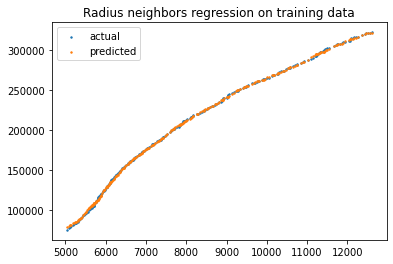

In [110]:
plt.scatter(X_train.to_numpy(), y_train.to_numpy(), label = 'actual', s = 2)
plt.scatter(X_train.to_numpy(), rnr.predict(X_train.to_numpy().reshape(-1, 1)), label = 'predicted', s = 2)
plt.title('Radius neighbors regression on training data')
ignore = plt.legend()

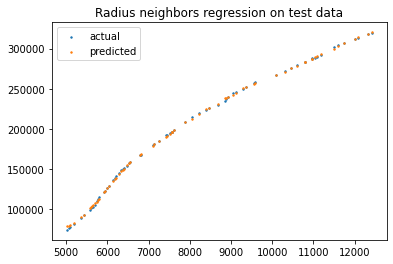

In [112]:
y_predicted = rnr.predict(X_test.to_numpy().reshape(-1, 1))

plt.scatter(X_test.to_numpy(), y_test.to_numpy(), label = 'actual', s = 2)
plt.scatter(X_test.to_numpy(), y_predicted, label = 'predicted', s = 2)
plt.title('Radius neighbors regression on test data')
igoore = plt.legend()

In [114]:
from sklearn.metrics import mean_squared_error, r2_score

print(f'MSE = {mean_squared_error(y_test, y_predicted)}.')
print(f'R2 = {r2_score(y_test, y_predicted)}')

MSE = 2056164.5457095774.
R2 = 0.9996170248532892


## Predict monthly MRR

In [102]:
seg_agg = seg[['month', 'Total paid customers', 'Segment 2 MRR']].groupby('month').sum()

In [118]:
X = seg_agg['Total paid customers']
y = seg_agg['Segment 2 MRR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15081947)

In [137]:
rnr = RadiusNeighborsRegressor(radius = 30000.0)
rnr.fit(X_train.to_numpy().reshape(-1, 1), y_train.to_numpy())

RadiusNeighborsRegressor(radius=30000.0)

In [138]:
y_predicted = rnr.predict(X_test.to_numpy().reshape(-1, 1))

In [140]:
comparison = pd.DataFrame({'Total paid customers': X_test, 'Actual MRR': y_test, 'Predicted MRR': y_predicted} )

In [142]:
comparison['pct-error'] = (comparison['Predicted MRR'] - comparison['Actual MRR'])/comparison['Actual MRR']
comparison

,Total paid customers,Actual MRR,Predicted MRR,pct-error
month,,,,
05,208769.068098,5.131740e+06,4.588234e+06,-0.105911
11,334155.752660,8.748490e+06,8.389245e+06,-0.041064
07,243863.149511,6.429270e+06,6.343360e+06,-0.013362


# Build models using the entire data